# Проект для "Викишоп" с BERT

# 1. Постановка задачи

## 1.1. Постановка задачи

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
Требуется обучить модель классифицировать комментарии на позитивные и негативные. 
Постройте модель со значением метрики качества F1 не меньше 0.75. 

## 1.2. Описание данных

**Признаки:**  
- text текст комментария.

**Целевой признак:** 

- toxic - целевой признак  

# 2. Импорт данных

## 2.1. Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import torch
import re
import transformers
import math as mt
import matplotlib.pyplot as plt
import spacy
import sys
import requests
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from io import BytesIO
from urllib.parse import urlencode
from pymystem3 import Mystem
from sklearn.utils import shuffle
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMClassifier
from tqdm import tqdm
from transformers import AutoModel
from transformers import BertForSequenceClassification
from huggingface_hub import notebook_login
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
warnings.filterwarnings('ignore')

In [2]:
notebook_login()

## 2.2. Импорт датасета

In [3]:
def read_data_set(pth1, pth2) -> pd.DataFrame:
    df = pd.DataFrame    
    try:
        df = pd.read_csv(pth1, index_col= 'Unnamed: 0')
    except OSError as e:
        df = pd.read_csv(pth2, index_col= 'Unnamed: 0')
    return df

In [4]:
pth1 = 'toxic_comments.csv'         
pth2 = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'

In [5]:
df = read_data_set(pth1, pth2);

In [6]:
df.info()

In [7]:
df.sample(10)

In [8]:
df.duplicated().sum()

In [9]:
df.isna().sum()

In [10]:
df.toxic.value_counts()

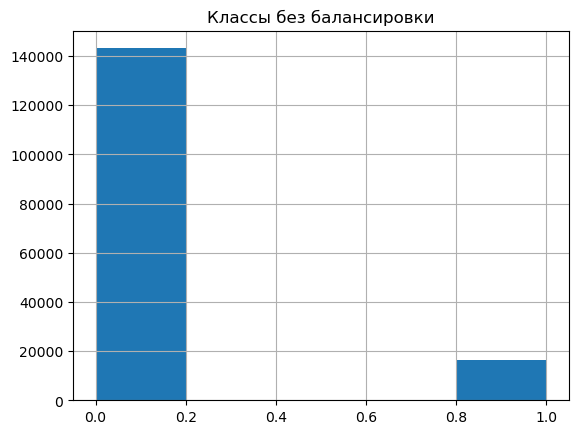

In [11]:
df['toxic'].hist(bins=5);
plt.title('Классы без балансировки')
plt.show()

**Анализ:**

1. Пропусков и дубликатов нет
2. Названия столбцов соответствуют snake_case
3. Классы не сбалансированы

Лематизируем твиты

Функцией ниже это сделать не получается. Придется использовать spacy

def lemma(text):
    m = Mystem() 
    return ''.join(m.lemmatize(text))   

In [12]:
def lemma_by_spacy_clear(text):
    doc = nlp(text)
    doc=" ".join([token.lemma_ for token in doc])
    doc=re.sub(r'[^a-zA-Z ]',' ',doc)
  
    return " ".join(doc.split())

In [13]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [14]:
tqdm.pandas()
df.text = df.text.progress_apply(lemma_by_spacy_clear)

Сэмплируем трейновую выборку

In [15]:
target = df['toxic']
features = df.drop('toxic', axis=1)

In [16]:
def upsample(features, target, repeat):   
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

**Вывод:** 

В ходе этапа:

1. Загрузили датасет
2. Провели анализ загруженого датаффрейма
3. Лематизировали твиты

Можно переходить к токенизации и подготовке эмбедингов 

## 3 Подготовка признаков для обучения

Токенизация

In [39]:
df_features = pd.DataFrame(features)
df_target=pd.DataFrame(target)
df_BERT_features = df_features.sample(n=2000,random_state=42)

In [40]:
df_BERT_target = target[df_BERT_features.index]
df_BERT_target = df_BERT_target.reset_index().drop_duplicates(subset='index', keep='last').set_index('index')

In [41]:
df_BERT_features.shape[0]

In [42]:
df_BERT_target.shape[0]

In [43]:
tokenizer = AutoTokenizer.from_pretrained('unitary/toxic-bert', local_files_only=False, truncation=True)
model = AutoModelForSequenceClassification.from_pretrained('unitary/toxic-bert', local_files_only=False)

In [44]:
#tokenizer = transformers.BertTokenizer(
    #vocab_file= 'vocab.txt',  truncation=True)
def tok(features):
    tokenized = df_BERT_features.text.apply(
        lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512))

    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
    attention_mask = np.where(padded != 0, 1, 0)
    return padded, attention_mask

In [45]:
padded, attention_mask = tok(df_BERT_features)

Эмбединги

In [46]:
def emb(padded, attention_mask, batch_size):
    embeddings = []
    for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
            batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
            attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])          
            with torch.no_grad():
                batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
            embeddings.append(batch_embeddings[0][:,0].numpy()) 
    return embeddings

In [47]:
embeddings = emb(padded, attention_mask, 100)

In [48]:
features_bert = np.concatenate(embeddings)

In [49]:
features_bert.shape

In [50]:
features_bert = features_bert.reshape(-1,1)

**Вывод:** 

В ходе этапа:

1. Провели токенизацию твитов
2. Построили эмбединги твитов

Можно переходить к постройке модели

# 4 Построение модели

## 4.1. Подготовка модели

**Строим модель**

In [51]:
X_train, X_test, y_train, y_test = train_test_split(features_bert, df_BERT_target, test_size=0.2, random_state=42)

In [52]:
param_grid = {}
model = LogisticRegression(class_weight='balanced')
gs = GridSearchCV(model, param_grid=param_grid,  scoring= 'f1')
gs.fit(X_train, y_train)
gs.best_score_

In [53]:
param_grid = {'n_estimators':[10,20,40], 
             'max_depth': [5,10,15]}  
model = RandomForestClassifier(class_weight='balanced')
gs = GridSearchCV(model, param_grid=param_grid,  scoring= 'f1')
gs.fit(X_train, y_train)
gs.best_score_

In [54]:
param_grid = {'n_estimators':[50,75,100], 
             'num_leaves=': [5,10,15]}  
model = LGBMClassifier(class_weight='balanced')
gs = GridSearchCV(model, param_grid=param_grid,  scoring= 'f1')
gs.fit(X_train, y_train)
gs.best_score_

In [55]:
param_grid = {'n_estimators':[10,20,40], 
             'max_depth': [5,10,15]}  
model = RandomForestClassifier(class_weight='balanced')
gs = GridSearchCV(model, param_grid=param_grid,  scoring= 'f1')
gs.fit(X_train, y_train)
gs.best_score_

**Вывод:** 

Лучшие результаты показал случайный лес

## 4.2. Тестирование модели

In [56]:
print('f1_score:', f1_score(y_test, gs.best_estimator_.predict(X_test)))

# 5 Вывод

## 5.1 Постановка задачи

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
Требуется обучить модель классифицировать комментарии на позитивные и негативные. 
Постройте модель со значением метрики качества F1 не меньше 0.75. 

## 5.2 Ход решения

В ходе решения задачи был загружен и обработан датасет сервиса "Викишоп".

В ходе анализа данных было выявлено следующее:

1. Пропусков и дубликатов нет
2. Названия столбцоов соответствуют snake_case
3. Классы не сбалансированы

В ходе импорта данных прзнаки датасета были лематизированы. Для увеличения количества записей с целевым признаком "1" выполнили семплирование датасета

В ходе подготовки выборок признак был токенезирован. Для токенезированного признака с помощью готовой модели BERT были подготовлены эмбединги.

По выборкам были построены модели 

## 5.3 Выводы

В ходе работы сумели построить модель, удовлетворяющую условию f1_score > 0.75

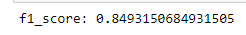